### A vanilla RNN trained to count number of 1's in a binary input stream
#### [Tutorial Link](http://peterroelants.github.io/posts/rnn_implementation_part01/) 

In [18]:
#Python imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm

np.random.seed(seed=1)

In [19]:
#Create dataset

n_samples = 20
sequence_len = 10 # number of timesteps

X = np.zeros((n_samples, sequence_len))

for i in range(n_samples):
    X[i, :] = np.around(np.random.rand(sequence_len)).astype(int)
    
#create targets for each sequence
t = np.sum(X, axis = 1)

print(X)

[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  1.  0.  1.  0.  1.  0.  0.]
 [ 1.  1.  0.  1.  1.  1.  0.  0.  0.  1.]
 [ 0.  0.  1.  1.  1.  0.  1.  1.  0.  1.]
 [ 1.  1.  0.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  1.  0.  1.  1.]
 [ 0.  0.  1.  0.  0.  1.  1.  1.  1.  1.]
 [ 1.  0.  0.  1.  0.  0.  1.  0.  1.  1.]
 [ 1.  1.  1.  0.  0.  1.  0.  1.  1.  1.]
 [ 0.  1.  0.  1.  0.  0.  1.  1.  0.  1.]
 [ 0.  1.  1.  0.  1.  1.  0.  1.  1.  1.]
 [ 0.  0.  1.  1.  0.  1.  1.  1.  1.  0.]
 [ 0.  0.  0.  0.  1.  1.  1.  1.  0.  0.]
 [ 1.  1.  1.  0.  1.  0.  1.  0.  1.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  1.  1.  0.]
 [ 0.  1.  1.  0.  0.  1.  0.  1.  1.  1.]
 [ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.]
 [ 0.  1.  1.  0.  1.  1.  1.  0.  0.  0.]
 [ 1.  0.  1.  0.  0.  1.  0.  1.  1.  1.]
 [ 0.  0.  1.  1.  1.  1.  0.  0.  1.  1.]]


In [20]:
# Define the forward step fucntions

def update_state(Xk, Sk, Wx, Wrec):
    """
    compute state k from previous state (Sk-1) and current input
    state (Xk) by use of input weights (Wx) and recursive
    weights (Wrec)
    """
    return Xk * Wx + Sk * Wrec

def forward_states(X, Wx, Wrec):
    """
    unfold the network and compute all state activations
    given the input (X) and input weights (Wx) and recursive
    weights (Wrec).
    Return the state activations in a matrix, the last column
    S[:, -1] cpntains the final activations.
    """
    
    # Initialize the state matrix with initial state as 0
    S = np.zeros((X.shape[0], X.shape[1]+1))
    
    # Use the recurrence relation defined by update_state
    for k in range(X.shape[1]):
        S[:,k+1]  = update_state(X[:,k], S[:,k], Wx, Wrec)
    return S

def cost(y, t):
    # return MSE loss
    return ((t-y)**2).sum() / n_samples

In [21]:
def output_gradient(y, t):
    """
    Compute the gradient of the MSE cost fucntions with 
    respect to the output y.
    """
    return 2.0 * (y - t) / n_samples

def backward_gradient(X, S, grad_out, Wrec):
    """
    Backpropogate the gradient computed at the output (grad_out)
    through the network. Acuumulate the parameter gradients for
    Wx and Wrec for each layer by addition. Return the parameter
    gradients as a tuple, and the gradients at ouput of each
    layer.
    """
    
    # Initialize the array that stores the gradients of the cost with respect to the states.
    grad_overtime = np.zeros((X.shape[0], X.shape[1]+1))
    grad_overtime[:, -1] = grad_out
    
    # Set the gradient accumulations to 0
    wx_grad = 0
    wrec_grad = 0
    
    for k in range(X.shape[1], 0, -1):
        # Compute the parameter gradients and accumulate the results
        wx_grad += np.sum(grad_overtime[:, k] * X[:, k-1])
        wrec_grad += np.sum(grad_overtime[:, k] * S[:, k-1])
        
        # Compute the gradient at the output of the previous layer
        grad_overtime[:, k-1] = grad_overtime[:, k] * Wrec
    
    return (wx_grad, wrec_grad), grad_overtime

In [22]:
# Perform gradient checking
# Set the weight parameters used during gradient checking
params = [1.2, 1.2]  # [wx, wRec]
# Set the small change to compute the numerical gradient
eps = 1e-7
# Compute the backprop gradients
S = forward_states(X, params[0], params[1])
grad_out = output_gradient(S[:,-1], t)
backprop_grads, grad_over_time = backward_gradient(X, S, grad_out, params[1])
# Compute the numerical gradient for each parameter in the layer
for p_idx, _ in enumerate(params):
    grad_backprop = backprop_grads[p_idx]
    # + eps
    params[p_idx] += eps
    plus_cost = cost(forward_states(X, params[0], params[1])[:,-1], t)
    # - eps
    params[p_idx] -= 2 * eps
    min_cost = cost(forward_states(X, params[0], params[1])[:,-1], t)
    # reset param value
    params[p_idx] += eps
    # calculate numerical gradient
    grad_num = (plus_cost - min_cost) / (2*eps)
    # Raise error if the numerical grade is not close to the backprop gradient
    if not np.isclose(grad_num, grad_backprop):
        raise ValueError('Numerical gradient of {:.6f} is not close to the backpropagation gradient of {:.6f}!'.format(float(grad_num), float(grad_backprop)))
print('No gradient errors found')

No gradient errors found


In [23]:
# Define plotting functions

# Define points to annotate (wx, wRec, color)
points = [(2,1,'r'), (1,2,'b'), (1,-2,'g'), (1,0,'c'), (1,0.5,'m'), (1,-0.5,'y')]

def get_cost_surface(w1_low, w1_high, w2_low, w2_high, nb_of_ws, cost_func):
    """Define a vector of weights for which we want to plot the cost."""
    w1 = np.linspace(w1_low, w1_high, num=nb_of_ws)  # Weight 1
    w2 = np.linspace(w2_low, w2_high, num=nb_of_ws)  # Weight 2
    ws1, ws2 = np.meshgrid(w1, w2)  # Generate grid
    cost_ws = np.zeros((nb_of_ws, nb_of_ws))  # Initialize cost matrix
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_ws):
        for j in range(nb_of_ws):
            cost_ws[i,j] = cost_func(ws1[i,j], ws2[i,j])
    return ws1, ws2, cost_ws

def plot_surface(ax, ws1, ws2, cost_ws):
    """Plot the cost in function of the weights."""
    surf = ax.contourf(ws1, ws2, cost_ws, levels=np.logspace(-0.2, 8, 30), cmap=cm.pink, norm=LogNorm())
    ax.set_xlabel('$w_{in}$', fontsize=15)
    ax.set_ylabel('$w_{rec}$', fontsize=15)
    return surf

def plot_points(ax, points):
    """Plot the annotation points on the given axis."""
    for wx, wRec, c in points:
        ax.plot(wx, wRec, c+'o', linewidth=2)

def get_cost_surface_figure(cost_func, points):
    """Plot the cost surfaces together with the annotated points."""
    # Plot figures
    fig = plt.figure(figsize=(10, 4))   
    # Plot overview of cost function
    ax_1 = fig.add_subplot(1,2,1)
    ws1_1, ws2_1, cost_ws_1 = get_cost_surface(-3, 3, -3, 3, 100, cost_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, cost_ws_1 + 1)
    plot_points(ax_1, points)
    ax_1.set_xlim(-3, 3)
    ax_1.set_ylim(-3, 3)
    # Plot zoom of cost function
    ax_2 = fig.add_subplot(1,2,2)
    ws1_2, ws2_2, cost_ws_2 = get_cost_surface(0, 2, 0, 2, 100, cost_func)
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, cost_ws_2 + 1)
    plot_points(ax_2, points)
    ax_2.set_xlim(0, 2)
    ax_2.set_ylim(0, 2)
    # Show the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    cbar = fig.colorbar(surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar.ax.set_ylabel('$\\xi$', fontsize=15, rotation=0, labelpad=20)
    cbar.set_ticklabels(['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    fig.suptitle('Cost surface', fontsize=15)
    return fig

def plot_gradient_over_time(points, get_grad_over_time):
    """Plot the gradients of the annotated point and how the evolve over time."""
    fig = plt.figure(figsize=(6.5, 4))  
    ax = plt.subplot(111)
    # Plot points
    for wx, wRec, c in points:
        grad_over_time = get_grad_over_time(wx, wRec)
        x = np.arange(-grad_over_time.shape[1]+1, 1, 1)
        plt.plot(x, np.sum(grad_over_time, axis=0), c+'-', label='({0}, {1})'.format(wx, wRec), linewidth=1, markersize=8)
    plt.xlim(0, -grad_over_time.shape[1]+1)
    # Set up plot axis
    plt.xticks(x)
    plt.yscale('symlog')
    plt.yticks([10**8, 10**6, 10**4, 10**2, 0, -10**2, -10**4, -10**6, -10**8])
    plt.xlabel('timestep k', fontsize=12)
    plt.ylabel('$\\frac{\\partial \\xi}{\\partial S_{k}}$', fontsize=20, rotation=0)
    plt.grid()
    plt.title('Unstability of gradient in backward propagation.\n(backpropagate from left to right)')
    # Set legend
    leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, numpoints=1)
    leg.set_title('$(w_x, w_{rec})$', prop={'size':15})
    
def get_grad_over_time(wx, wRec):
    """Helper func to only get the gradient over time from wx and wRec."""
    S = forward_states(X, wx, wRec)
    grad_out = output_gradient(S[:,-1], t).sum()
    _, grad_over_time = backward_gradient(X, S, grad_out, wRec)
    return grad_over_time

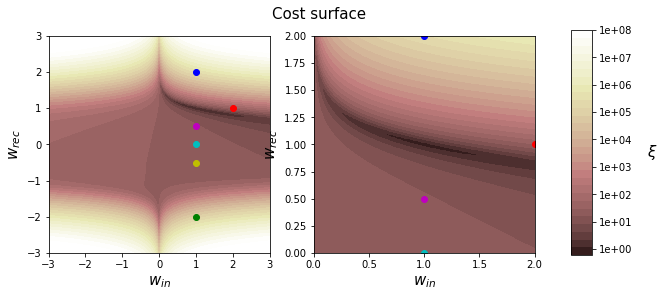

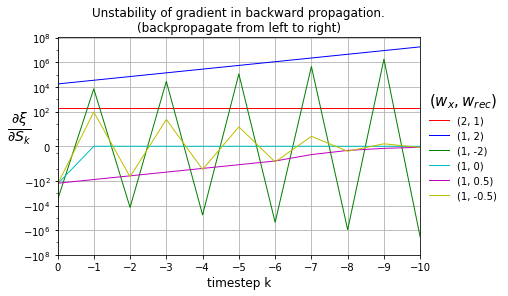

In [24]:
# Plot cost surface and gradients

# Get and plot the cost surface figure with markers
fig = get_cost_surface_figure(lambda w1, w2: cost(forward_states(X, w1, w2)[:,-1] , t), points)

# Get the plots of the gradients changing by backpropagating.
plot_gradient_over_time(points, get_grad_over_time)
# Show figures
plt.show()

In [25]:
# Define Rprop optimization function

def update_rprop(X, t, W, W_prev_sign, W_delta, eta_p, eta_n):
    """
    Upadte Rprop values in one iteration
    X: input data
    t: targets
    W: Current weight parameters
    W_prev_sign: Previous sign of the W gradient
    W_delta: Rprop update values (Delta)
    eta_p, eta_n: Rprop hyperparameters
    """
    
    # Perform forward and backward pass to get the gradients
    S = forward_states(X, W[0], W[1])
    grad_out = output_gradient(S[:, -1], t)
    W_grads, _ = backward_gradient(X, S, grad_out, W[1])
    W_sign = np.sign(W_grads) # Sign of new gradient
    # Update the Delta (update value) for each weight parameter seperately
    for i, _ in enumerate(W):
        if(W_sign[i] == W_prev_sign[i]):
            W_delta[i] *= eta_p
        else:
            W_delta[i] *= eta_n
    return W_delta, W_sign

In [28]:
# Perform Rprop optimization

# Set hyperparameters 
eta_p, eta_n = 1.2, 0.5

# Set initial parameters
W = [-1.5, 2] # [Wx Wrec]
W_delta = [0.001, 0.001] # Update values (Delta) for W
W_sign = [0, 0] # previous sign of W_grads

lsWs = [(W[0], W[1])] # List of weights to plot
# Iterate over 500 steps

for i in range(500):
    # Get the update values and sign of the last gradient
    W_delta, W_sign = update_rprop(X, t, W, W_sign, W_delta,
                                  eta_p, eta_n)
    # Update each weight parameter seperately
    for i, _ in enumerate(W):
        W[i] -= W_sign[i] * W_delta[i]
    lsWs.append((W[0], W[1]))
print('Final weights are: Wx = {0}, Wrec = {1}'.format(W[0], W[1]))


Final weights are: Wx = 1.001355547207059, Wrec = 0.9996744737846419


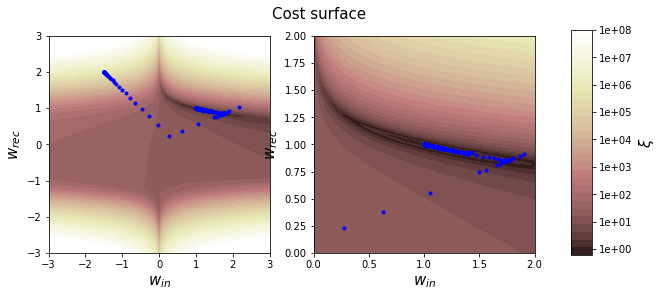

In [30]:
# Plot the cost surface with the weights over the iterations.

# Define plot function
def plot_optimisation(ls_of_ws, cost_func):
    """Plot the optimisation iterations on the cost surface."""
    ws1, ws2 = zip(*ls_of_ws)
    # Plot figures
    fig = plt.figure(figsize=(10, 4))
    # Plot overview of cost function
    ax_1 = fig.add_subplot(1,2,1)
    ws1_1, ws2_1, cost_ws_1 = get_cost_surface(-3, 3, -3, 3, 100, cost_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, cost_ws_1 + 1)
    ax_1.plot(ws1, ws2, 'b.')
    ax_1.set_xlim([-3,3])
    ax_1.set_ylim([-3,3])
    # Plot zoom of cost function
    ax_2 = fig.add_subplot(1,2,2)
    ws1_2, ws2_2, cost_ws_2 = get_cost_surface(0, 2, 0, 2, 100, cost_func)
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, cost_ws_2 + 1)
    ax_2.set_xlim([0,2])
    ax_2.set_ylim([0,2])
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, cost_ws_2)
    ax_2.plot(ws1, ws2, 'b.')
    # Show the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    cbar = fig.colorbar(surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar.ax.set_ylabel('$\\xi$', fontsize=15)
    cbar.set_ticklabels(['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    plt.suptitle('Cost surface', fontsize=15)
    plt.show()
    
# Plot the optimisation
plot_optimisation(lsWs, lambda w1, w2: cost(forward_states(X, w1, w2)[:,-1] , t))
plt.show()

In [31]:
test_input = np.asmatrix([[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1]])
test_output = forward_states(test_input, W[0], W[1])[:, -1]
print('Target output: {:d} vs Model Output: {:.2f}'.format(test_input.sum(), test_output[0]))

Target output: 5 vs Model Output: 5.00
